## Regularized Adaprive Prediction Sets (RAPS)

## 1. Conformal Prediction 

Conformal Prediction is a general framework, not a specific algorithm, that transforms any base model into one that outputs prediction sets with guaranteed coverge, and can be viewed as an approach for generating predictive sets that satisfy the coverage property in Eq. (1) (Vovk et al., 1999; 2005). 

Instead of predicting a single label, we out a set of labels $C(x)$ that
$$ \mathbb{P}(Y \in C(X)) \ge 1 - \alpha, $$
for a pre-specified confidence level $\alpha$ such as 10% (e.g. $\alpha = 0.1$ for 90\% coverage).

RAPS constitutes a conformal prediction method explicitly intended for high-cardinality multi-class classification.

Let's beginn with a small example!

Instead of training a full neural network, we will simulate class probabilities to illustrate how RAPS works. 


In [315]:
import numpy as np 
import matplotlib.pyplot as plt

# Set random seed for reproduciblity
np.random.seed(0)

# Number of clusters
K = 6

# Number of calibration and test points 
n_cal = 500
n_test = 200

def random_probs(n, K): 
    """Simulate logits and turn them into probabilities."""
    logits = np.random.randn(n, K)
    exp = np.exp(logits)
    return exp / exp.sum(axis=1, keepdims=True)

# calibration data 
probs_cal = random_probs(n_cal, K)
y_cal = np.random.randint(0, K, size=n_cal)

# test data
probs_test = random_probs(n_test, K) 
y_test = np.random.randint(0, K, size=n_test)

## CIFAR10 Implementierung

In [316]:
import os, urllib.request, tarfile, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# download & load CIFAR-10 
def load_cifar10_6():
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    folder = "cifar-10-batches-py"
    
    # Download archive if missing
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

    # Extract if missing
    if not os.path.exists(folder):
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall()
    # helper to load a batch and return images and labels
    def load_batch(path):
        with open(path, "rb") as f:
            batch = pickle.load(f, encoding="bytes")
        X = batch[b"data"].reshape(-1, 3, 32, 32).astype("float32") / 255.0
        X = np.transpose(X, (0, 2, 3, 1))  # channels-last
        y = np.array(batch[b"labels"])
        return X, y

    # Load 5 train batches
    X_list, y_list = [], []
    for i in range(1, 6):
        Xb, yb = load_batch(os.path.join(folder, f"data_batch_{i}"))
        X_list.append(Xb)
        y_list.append(yb)
    X_train = np.concatenate(X_list, axis=0)
    y_train = np.concatenate(y_list, axis=0)

    # Load test data
    X_test, y_test = load_batch(os.path.join(folder, "test_batch"))

    # Keep only 6 classes (the first 6)
    selected = [0, 1, 2, 3, 4, 5]
    mask_tr = np.isin(y_train, selected)
    mask_te = np.isin(y_test,  selected)
    X_train, y_train = X_train[mask_tr], y_train[mask_tr]
    X_test,  y_test  = X_test[mask_te],  y_test[mask_te]

    # Relabel classes to 0,...,5
    relabel = {old: i for i, old in enumerate(selected)}
    y_train = np.array([relabel[c] for c in y_train])
    y_test  = np.array([relabel[c] for c in y_test])

    # Optionally subsample training data for faster training
    n_sub = 10000  
    if n_sub is not None and n_sub < len(X_train):
        rng = np.random.RandomState(0)
        idx = rng.choice(len(X_train), size=n_sub, replace=False)
        X_train = X_train[idx]
        y_train = y_train[idx]

    # Flatten images
    X_train = X_train.reshape(len(X_train), -1)
    X_test  = X_test.reshape(len(X_test),  -1)
    return X_train, y_train, X_test, y_test

# Load CIFAR-10 data (6 classes)
X_full_flat, y_full, X_test_flat, y_test = load_cifar10_6()

# split into train and calibration sets
X_train, X_cal, y_train, y_cal = train_test_split(
    X_full_flat, y_full, test_size=0.2, random_state=0, stratify=y_full
)

# Train a simple MLP classifier
clf = MLPClassifier(hidden_layer_sizes=((256,)), max_iter=20, random_state=0)
clf.fit(X_train, y_train)

# Predict probabilities for calibration and test data
probs_cal = clf.predict_proba(X_cal)
probs_test = clf.predict_proba(X_test_flat)

# number of classes
K = probs_cal.shape[1]

# Sort probabilities 
s_cal  = np.sort(probs_cal,  axis=1)[:, ::-1]
I_cal  = np.argsort(probs_cal,  axis=1)[:, ::-1]
s_test = np.sort(probs_test, axis=1)[:, ::-1]
I_test = np.argsort(probs_test, axis=1)[:, ::-1]

print("probs_cal:", probs_cal.shape, "probs_test:", probs_test.shape, "K =", K)


probs_cal: (2000, 6) probs_test: (6000, 6) K = 6


/Users/bisanabusalih/Desktop/mein_projekt/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


## 2. Sorted scores and indices 

Following the RAPS document, we will work with **sortd scores s** anr their corresponding class indices **I** (associated permutation of classes):

- $s_{i,j}$ is the $j$-th largest score for example $i$,
- $I_{i,j}$ is the class index corresponding to $s_{i,j}$.

In [317]:
def sort_scores(probs): 
    """Sort probabilities in descending order per row and return both  the sorted scores and the index permutation."""
    order = np.argsort(-probs, axis=1) 
    s_sorted = np.take_along_axis(probs, order, axis=1) 
    return s_sorted, order 

s_cal, I_cal = sort_scores(probs_cal)
s_test, I_test = sort_scores(probs_test)

s_cal[:3], I_cal[:3]

(array([[0.32241786, 0.28792188, 0.14744444, 0.130065  , 0.08291905,
         0.02923172],
        [0.8247302 , 0.10246465, 0.03144575, 0.02729696, 0.01232091,
         0.00174154],
        [0.31412694, 0.30632073, 0.14524782, 0.12379787, 0.09536069,
         0.01514598]], dtype=float32),
 array([[1, 0, 2, 3, 4, 5],
        [0, 1, 2, 4, 3, 5],
        [2, 4, 5, 3, 0, 1]]))

Let's visualize it!

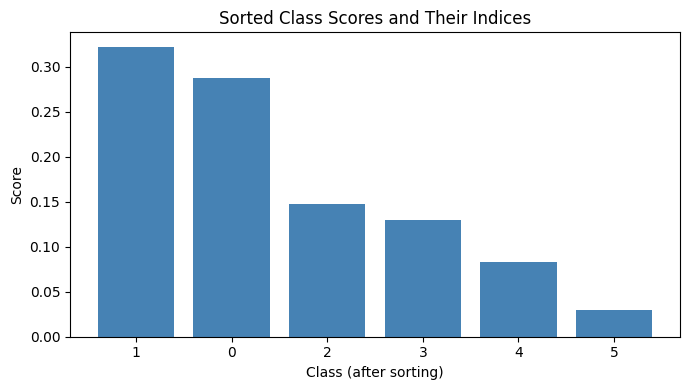

In [318]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

scores = s_cal[0]
indices = I_cal[0]

ax.bar(range(K), scores, color="steelblue")
ax.set_xticks(range(K))
ax.set_xticklabels(indices)
ax.set_xlabel("Class (after sorting)")
ax.set_ylabel("Score")
ax.set_title("Sorted Class Scores and Their Indices")

plt.tight_layout()
plt.show()

## 3. Naive Prediction Sets 

A Naive prediction set is constructed by sorting the class probabilities in decreasing order and selecting the most likely classes until the cumulative probability  reaches the traget level $1 - \alpha$. 

Given sorted scores $s_1 \ge s_2 \ge \dots \ge s_K$ and the corresponding class indices $I_1, \dots, I_K$.
- the procedure starts with $L = 1$ and increases $L$ until
$\sum_{i=1}^{L} s_i \ge 1- \alpha$

- An optional randomization step can be used to break ties.

- Let $$V = \frac{\sum_{i=1}^{L} s_i - (1 - \alpha)}{s_L},
\qquad$$
$$
U \sim \text{Unif}(0,1), $$

- and if $(U \le V)$ the set size is reduced by one.

- The resulting naive prediction set is 
$$
\{ I_1, \dots, I_L\},
$$

In [319]:
def naive_prediction_set(alpha, s_row, I_row, rand=False): 
    """Naive 1-alpha prediction set for one data point."""
    L = 1
    # increase L until cumulative mass exceeds 1 - alpha 
    while s_row[:L].sum() < 1 - alpha and L < len(s_row):
        L = L + 1 

    if rand and L > 0:
        # optional randomization as in standard conformal prediction 
        U = np.ramdom.rand() 
        V = (s_row[:L].sum() - (1 - alpha)) / s_row[L-1]
        if U <= V:
            L = L - 1 

    return I_row[:L]

## 4. RAPS Conformal Calibration 

RAPS uses a calibration step to find a value (threshold) that controls how large the prediction sets will be.  
To get this threshold, we first compute a score for every example in the calibration set.

For each calibration example, we sort the class probabilities and look at the position of the true label.  

- Let $s_{i,1} \ge s_{i,2} \ge \dots$ be the sorted scores
- and let $L_i$ be the rank of the true class.

The RAPS score for this example is

$$
E_i = \sum_{j=1}^{L_i} s_{i,j} + \lambda\, (L_i - k_{\text{reg}})_+ .
$$

Here, $(t)_+ = \max(t, 0)$ adds a penalty when the true label appears late in the list.

- Optionally subtract a randomized term $U_i * s_{i,L_i}$.

- If randomization is used, the score is slightly adjusted:

$$
E_i^{\text{rand}} = E_i - U_i\, * s_{i,L_i}, \qquad U_i \sim \text{Unif}(0,1).
$$

- Take a high quantile of the $E_i$ values as the calibration threshold $\hat{\tau}$. 






In [320]:
def raps_calibration_scores(s_cal, I_cal, y_cal, lambda_=0.1, k_reg=3, rand=True):
    """Compute RAPS calibration scores E_i fpr each calibration example."""
    n, K = s_cal.shape
    E = np.zeros(n)
    for i in range(n):
        # Find the rank of the true label in the sorted List
        L_i = np.where(I_cal[i] == y_cal[i])[0][0]

        Ei = s_cal[i, :L_i + 1].sum() + lambda_ * max(0, (L_i + 1) - k_reg)

        # Optional randomization step 
        if rand: 
            U = np.random.rand()
            Ei = Ei - U * s_cal[i, L_i]

        E[i] = Ei

    return E 

lambda_ = 0.1
k_reg = 3
E_cal = raps_calibration_scores(s_cal, I_cal, y_cal, lambda_=lambda_, k_reg=k_reg, rand=True)
E_cal[:10]


array([0.19784284, 0.36103541, 0.37065786, 0.08120744, 0.13287456,
       0.47607845, 0.81037593, 0.58881569, 0.37948275, 0.55391246])

- After we have all scores $E_1, \dots, E_n$,  
the calibration threshold is chosen as a specific quantile:

$$
\hat{\tau}_{ccal} = E_{(k)}, \qquad 
k = \lceil (1 - \alpha)(n + 1) \rceil .
$$
where $E_{(k)}$ is the $k$-th smallest calibration score.

In [321]:
def raps_tau_hat(E, alpha):
    """Compute the conformal calibration threshold tau_hat from scores E."""
    n = len(E)
    k = int(np.ceil((1 - alpha) * (n + 1)))
    k = min(max(k, 1), n)
    E_sorted = np.sort(E)
    tau_hat = E_sorted[k-1]
    return tau_hat

alpha = 0.1
tau_hat = raps_tau_hat(E_cal, alpha)
tau_hat

np.float64(1.0176525734364987)

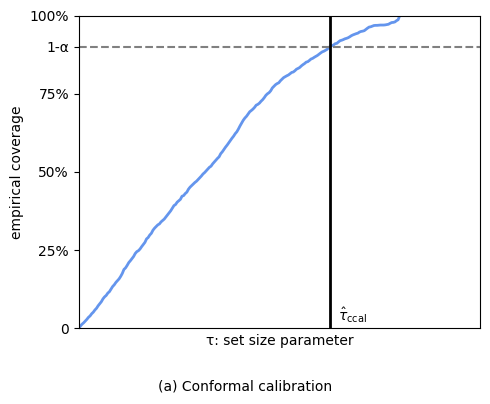

In [322]:
# Generate empirical coverage curve over different thresholds tau
taus = np.linspace(min(E_cal), max(E_cal), 200)
empirical_coverage = []

for t in taus:
    # coverage if we used threshold t instead of tau_hat
    cover = np.mean([E_cal[i] <= t for i in range(len(E_cal))])
    empirical_coverage.append(cover)

plt.figure(figsize=(5,4))
plt.plot(taus, empirical_coverage, color="cornflowerblue", linewidth=2)

# target line 1 - alpha
plt.axhline(1-alpha, linestyle="--", color="gray",  linewidth=1.5)

# vertical line at tau_hat
# berechne die Stelle, wo coverage 1 - alpha erreicht
idx = np.argmin(np.abs(np.array(empirical_coverage) - (1-alpha)))
tau_hat_mapped = taus[idx]

plt.axvline(tau_hat_mapped , color="black", linewidth=2)
plt.text(tau_hat + 0.09, 0.01, r"$\hat{\tau}_{\mathrm{ccal}}$", color="black", ha="center", va="bottom")
# 0.02 - 2.789, 0.01, 

x_min, x_max = taus[0], taus[-1]
extra = 0.25 * (x_max - x_min)
plt.xlim(x_min, x_max + extra)

plt.ylim(0, 1.0)
plt.yticks([0, 0.25, 0.50, 0.75, 1-alpha , 1.0],
           ["0", "25%", "50%", "75%", "1-α", "100%"])

plt.xticks([])


plt.ylabel("empirical coverage")
plt.xlabel("τ: set size parameter")
plt.figtext(0.5, 0.01, "(a) Conformal calibration", ha="center")

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()



## 5. RAPS Prediction Sets 

Once the calibration threshold $ \hat{\tau}_{ccal} $ is known, we can construct  prediction sets for new inputs.  
RAPS modifies the cumulative sum of sorted probabilities by adding a penalty to larger sets, controlled by the parameters $ \lambda $ and $ k_{\text{reg}} $.

For a test example with sorted scores $s_1 \ge s_2 \ge \dots$ and the associated permutation of classes $I$, $ \hat{\tau}_{ccal} $ from (4) , $ k_{\text{reg}} $, $\lambda $ , boolean rand we :   

1. Find the smallest L such that the RAPS sum is Large enough 
$$ \sum_{i=1}^j s_i + \lambda (j - k_{\text{reg}})_+ \; \ge\  \hat{\tau}_{ccal}$$
- At the end we obtain : $L = L_0 + 1$

2. Optionally : apply the small randomization
- First Draw a random value $U \sim \text{Unif}(0,1)$
- Then Compute how far the penalized sum exceeds the threshold:
$$V = \frac{
\sum_{j=1}^{L} s_j + \lambda (L - k_{\text{reg}})_+ - \hat{\tau}_{ccal}
}{
s_L + \lambda\, \mathbf{1}(L > k_{\text{reg}})
}.$$
- Then if 
$V \le U,$
then reduce the set size .
3. Return the prediction set : $C = \{ I_1, I_2, \dots, I_L \}$


In [323]:
def raps_prediction_set(s_row, I_row, tau_hat, lambda_=0.1, k_reg=3, rand=True):
    """Construct a RAPS prediction set for one test example."""
    K = len(s_row)
    L = 0
    for j in range(K):
        cum_sum = s_row[:j+1].sum()
        penalty = lambda_ * max(0, (j+1) - k_reg)
        if cum_sum + penalty <= tau_hat:
            L = j + 1
        else:
            break

    # optional randomization around the boundary
    if L < K:
        L_candidate = L + 1
    else:
        L_candidate = L

    if rand and L_candidate > 0 and L_candidate <= K:
        U = np.random.rand()
        j = L_candidate - 1
        cum_sum_L = s_row[:L_candidate].sum()
        penalty_L = lambda_ * max(0, L_candidate - k_reg)
        numerator = cum_sum_L + penalty_L - tau_hat
        denom = s_row[j] + (lambda_ if L_candidate > k_reg else 0)
        V = numerator / denom if denom > 0 else 1.0
        if V <= U:
            L = L_candidate

    return I_row[:max(L, 1)]

# example RAPS set for the first test point
raps_example = raps_prediction_set(s_test[0], I_test[0], tau_hat,
                                   lambda_=lambda_, k_reg=k_reg, rand=True)
raps_example

array([3, 5, 2, 0])

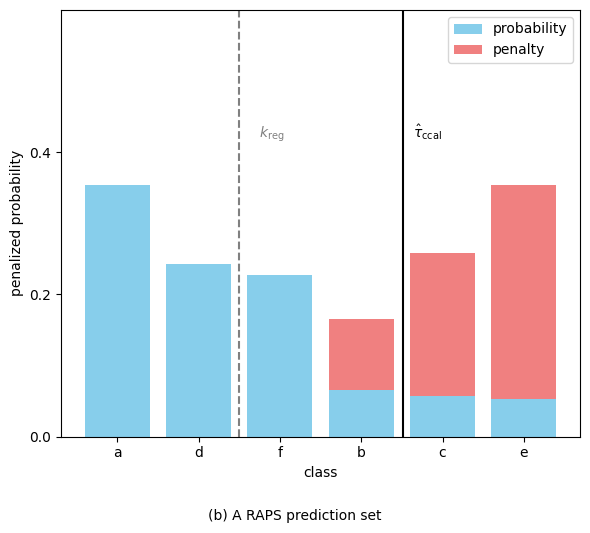

In [324]:
example_id = 0
scores = s_test[example_id]      # sorted scores
indices = I_test[example_id]     # corresponding classes

K = len(scores)
class_map = {0:"b", 1:"e", 2:"f", 3:"a", 4:"c", 5:"d"} # Mapping von indices to letters 
labels = [class_map[i] for i  in indices]

penalty_terms = []
penalized = []

for j in range(K):
    penalty = lambda_ * max(0, (j+1) - k_reg)
    penalty_terms.append(penalty)
    penalized.append(scores[j] + penalty)

plt.figure(figsize=(6,5))

# Plot bars: first probabilities, then penalties stacked
plt.bar(range(K), scores, color="skyblue", label="probability")
plt.bar(range(K), penalty_terms, bottom=scores, color="lightcoral", label="penalty")


# mark k_reg
plt.axvline(k_reg - 1.5, linestyle="--", color="gray")
plt.text(k_reg - 1.1, 0.42, r"$k_{\mathrm{reg}}$", color="gray", ha="center")

# mark tau_hat
plt.axvline(tau_hat + 2.5, linestyle="-", color="black")
plt.text(tau_hat + 2.8 , 0.42, r"$\hat{\tau}_{\mathrm{ccal}}$", color="black", ha="center")

plt.xticks(range(K), labels)

plt.ylim(0, 0.6)
plt.yticks([0.0, 0.2, 0.4])

plt.ylabel("penalized probability")
plt.xlabel("class")

plt.legend(loc="upper right")


plt.figtext(0.5, -0.05, "(b) A RAPS prediction set", ha="center")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()